In [1]:
import osmnx as ox
import geopandas as gpd
import osmium
import time
import pandas as pd
import numpy as np
import shapely.wkb as wkblib
import shapely.wkt

from PIL import Image, ImageDraw, ImageFont

from shapely import affinity
from shapely.geometry import Point
from matplotlib.lines import Line2D

from utils import add_border

from shapely.ops import cascaded_union

######## CONSTANTS
img_path = 'Sarajevo.png'
IVANA_ALCOHOL_DIST_THRS_M = 500

In [3]:
# Shapefile obtained in: https://gadm.org/download_country_v3.html
bosnia_shp = gpd.read_file('gadm36_BIH_shp/gadm36_BIH_3.shp')
bosnia_shp.head(2)

,GID_0,NAME_0,GID_1,NAME_1,NL_NAME_1,GID_2,NAME_2,NL_NAME_2,GID_3,NAME_3,VARNAME_3,NL_NAME_3,TYPE_3,ENGTYPE_3,CC_3,HASC_3,geometry
0,BIH,Bosnia and Herzegovina,BIH.1_1,Brčko,None,BIH.1.1_1,Brčko,None,BIH.1.1.1_1,Brčko,None,None,Opčine,Commune,None,None,"POLYGON ((18.95796 44.86178, 18.95663 44.86045..."
1,BIH,Bosnia and Herzegovina,BIH.2_1,Federacija Bosna i Hercegovina,None,BIH.2.1_1,Bosnian Podrinje,None,BIH.2.1.1_1,Foča-Ustikolina,None,None,Opčine,Commune,None,None,"POLYGON ((18.61360 43.61728, 18.60750 43.62007..."


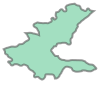

In [4]:
saravejo_pol = cascaded_union(bosnia_shp.loc[bosnia_shp['NAME_2'] == 'Sarajevo']['geometry'])
saravejo_pol

# t = affinity.rotate(t, 90, 'center').wkt # rotate 90 degrees

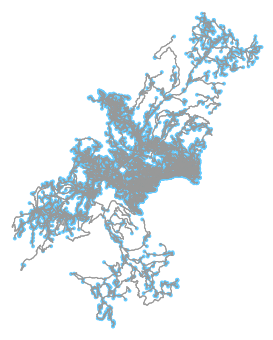

In [5]:
%%time
G = ox.core.graph_from_polygon(saravejo_pol, simplify=True)
fig, ax = ox.plot_graph(G)

# Extract amenity map data

In [6]:
%%time
class Pyosmium(osmium.SimpleHandler):          # class must inherit from osmium.SimpleHandler
    def __init__(self, pbf_path):
        osmium.SimpleHandler.__init__(self)        # initialize pyosmium
        self.names = []                            # store points names
        self.amenities = []
        self.wkb_fab = osmium.geom.WKBFactory()    # builds geometry over OSM objects
        self.points = []                           # store points geometries
        self.lats = []                           
        self.longs = []                           
            
        print('loading/processing pbf file...')
        self.apply_file(pbf_path, locations=True)  # initialize osm.pbf file process
        self.df = pd.DataFrame({'name': self.names, 'amenity': self.amenities, 
                                'point': self.points, 'lat': self.lats, 'long': self.longs}) # convert all data to DataFrame
        
        
    def node(self, node):
        # TagList can't be converted to dict automatically, see:
        # https://github.com/osmcode/pyosmium/issues/106
        tags_dict = {tag.k: tag.v for tag in node.tags}
        wkb = self.wkb_fab.create_point(node)   # extract Point's hex location data
        points = wkblib.loads(wkb, hex=True)    # convert hex data to WKB geometry format
        self.points.append(points)              # store geometry in list
        self.lats.append(points.xy[1][0])
        self.longs.append(points.xy[0][0])
        self.amenities.append(tags_dict['amenity'] if 'amenity' in tags_dict.keys() else '')
        self.names.append(tags_dict['name'] if 'name' in tags_dict.keys() else '') 
            
# obtained from https://download.geofabrik.de/europe/bosnia-herzegovina.html             
# PBF_PATH = 'bosnia-herzegovina-latest.osm.pbf' 
# bosnia_pyosmium = Pyosmium(PBF_PATH)
# bosnia_pyosmium.df.to_csv('bosnia_nodes.csv', index=False)


loading/processing pbf file...
CPU times: user 26min 11s, sys: 16.1 s, total: 26min 28s
Wall time: 26min 49s


In [7]:
df = pd.read_csv('bosnia_nodes.csv')

nice_amenities = ['restaurant', 'fuel', 'fast_food', 'cafe', 
                  'pub', 'bar', 'biergarten', 'nightclub', 'brothel',
                  'hookah_lounge']

nice_amenities = df.loc[df['amenity'].isin(nice_amenities)].copy()
nice_amenities['point'] = nice_amenities['point'].apply(lambda elem: shapely.wkt.loads(elem))

nice_amenities = gpd.GeoDataFrame(nice_amenities, geometry='point')
nice_amenities.crs = {'init' :'epsg:4326'}

nice_amenities.head()

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (0,1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


,name,amenity,point,lat,long
56275,Stara Bašta,restaurant,POINT (16.84572 44.97633),44.976330,16.845716
73233,Terex,fuel,POINT (18.35902 43.82904),43.829043,18.359015
76291,Nešković,fuel,POINT (18.78175 43.91146),43.911457,18.781747
76292,Nešković,fuel,POINT (18.80071 43.93687),43.936866,18.800710
79076,Nestro,fuel,POINT (18.69374 44.55644),44.556442,18.693740


## Filter only places in Sarajevo

In [8]:
sarajevo_pol = gpd.GeoDataFrame(gpd.GeoSeries(saravejo_pol), geometry=0)
sarajevo_pol.crs = {'init' :'epsg:4326'}

nice_amenities_s = gpd.sjoin(nice_amenities, 
                             sarajevo_pol, 
                             how='left', op='within')

nice_amenities_s = nice_amenities_s.loc[~nice_amenities_s['index_right'].isna()]
nice_amenities_s.head()

/usr/local/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


,name,amenity,point,lat,long,index_right
82582,"""UMAX GROUP"" d.o.o. Sarajevo",fuel,POINT (18.33360 43.90243),43.902427,18.333600,0.0
144682,Art,cafe,POINT (18.41228 43.86760),43.867595,18.412277,0.0
160965,Golf club,restaurant,POINT (18.40932 43.88524),43.885238,18.409319,0.0
162634,Caffe bar Stari Ilijaš,pub,POINT (18.26680 43.94657),43.946571,18.266801,0.0
162637,Restoran Jasmin,restaurant,POINT (18.26693 43.94643),43.946435,18.266930,0.0


# Buffer points to alcohol distance

In [9]:
nice_amenities_s = nice_amenities_s.to_crs(epsg=3395)

nice_amenities_s['buffered_points'] = nice_amenities_s.buffer(IVANA_ALCOHOL_DIST_THRS_M).to_crs(4326)
nice_amenities_s = gpd.GeoDataFrame(nice_amenities_s, geometry='buffered_points')

nice_amenities_s.head()


,name,amenity,point,lat,long,index_right,buffered_points
82582,"""UMAX GROUP"" d.o.o. Sarajevo",fuel,POINT (2040887.016 5420715.200),43.902427,18.333600,0.0,"POLYGON ((18.33809 43.90243, 18.33807 43.90211..."
144682,Art,cafe,POINT (2049645.322 5415354.006),43.867595,18.412277,0.0,"POLYGON ((18.41677 43.86759, 18.41675 43.86728..."
160965,Golf club,restaurant,POINT (2049315.995 5418069.124),43.885238,18.409319,0.0,"POLYGON ((18.41381 43.88524, 18.41379 43.88492..."
162634,Caffe bar Stari Ilijaš,pub,POINT (2033451.008 5427514.047),43.946571,18.266801,0.0,"POLYGON ((18.27129 43.94657, 18.27127 43.94625..."
162637,Restoran Jasmin,restaurant,POINT (2033465.335 5427493.093),43.946435,18.266930,0.0,"POLYGON ((18.27142 43.94643, 18.27140 43.94612..."


# Count how many alcohol places reach a node given IVANA_ALCOHOL_DIST_THRS_M

In [10]:
node_counts = {}
for uu, vv, kkey, ddata in G.edges(keys=True, data=True):
    uu_data = G.nodes[uu]
    uu_point = Point(uu_data['x'], uu_data['y'])
    uu_alcohol_count = nice_amenities_s.contains(uu_point).sum()
    node_counts[uu] = uu_alcohol_count
        
    vv_data = G.nodes[vv] 
    vv_point = Point(vv_data['x'], vv_data['y'])
    vv_alcohol_count = nice_amenities_s.contains(vv_point).sum()
    node_counts[vv] = vv_alcohol_count

## Unpack Data and define edge alcohol potential as avg(alcohol_potential(uu), alcohol_potential(vv))

In [11]:
u = []
v = []
key = []
data = []
for uu, vv, kkey, ddata in G.edges(keys=True, data=True):
    u.append(uu)
    v.append(vv)
    key.append(kkey)
    
    n_alcohol_uu = node_counts[uu]
    n_alcohol_vv = node_counts[vv]
    n_alcohol = np.mean([n_alcohol_uu, n_alcohol_vv])
        
    ddata['n_alcohol'] = n_alcohol
    data.append(ddata)

## Assign Each Segment a Color Based on its Length

In [12]:
# List to store colors
roadColors = []

# The length is in meters
for item in data:
    if "n_alcohol" in item.keys():
        
        if item["n_alcohol"] >= 1 and item["n_alcohol"] <= 5:
            color = "#07f507" # Green
            
        elif item["n_alcohol"] >= 6 and item["n_alcohol"] <= 10:
            color = "#e69419" # Orange
            
        elif item["n_alcohol"] >= 10 and item["n_alcohol"] <= 15:
            color = "#fc00e7" # Pink
            
        elif item["n_alcohol"] > 15:
            color = "#d40a47" # Red
            
        else:
            color = "w"
             
    roadColors.append(color)

## Assign Each Segment a Width Based on its type

In [13]:
# List to store linewidths
roadWidths = []

for item in data:
    if item["n_alcohol"] >= 1 and item["n_alcohol"] <= 5:
        linewidth = 1

    elif item["n_alcohol"] >= 5 and item["n_alcohol"] <= 10:
        linewidth = 1

    elif item["n_alcohol"] >= 10 and item["n_alcohol"] <= 15:
        linewidth = 1

    elif item["n_alcohol"] > 15:
        linewidth = 1

    else:
        linewidth = .5
        
    roadWidths.append(linewidth)

# Create map

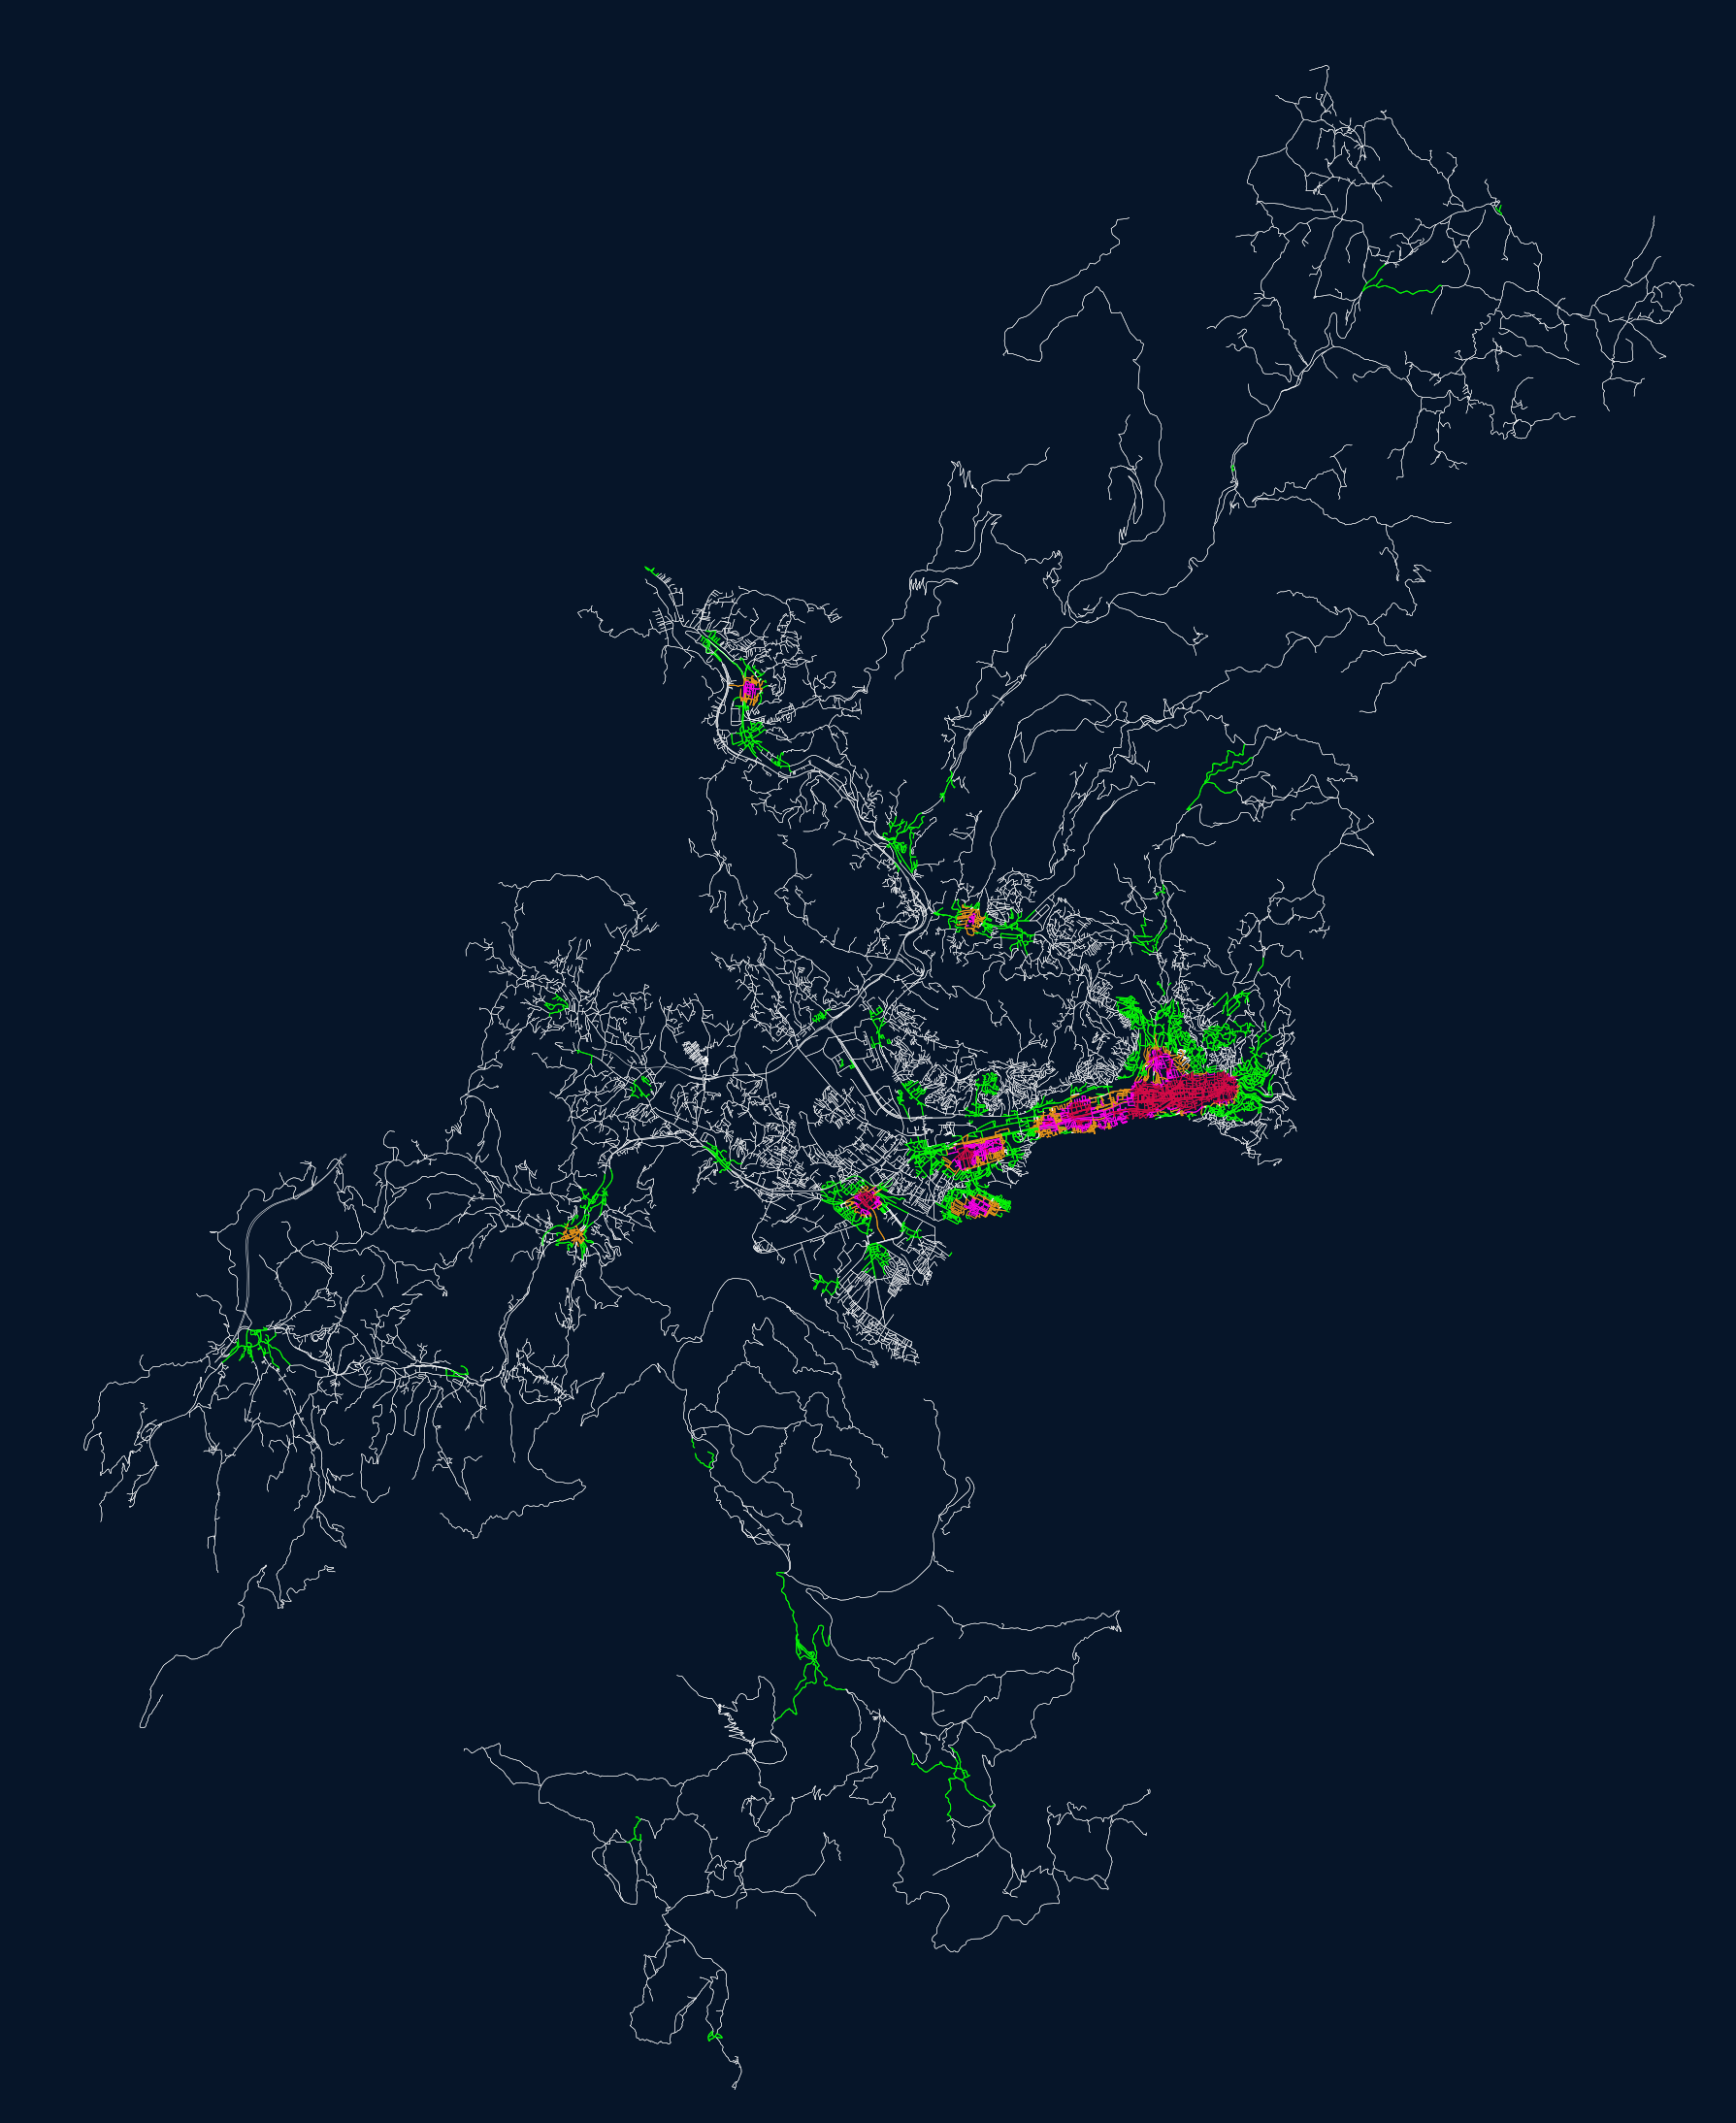

In [14]:
# Center of map
latitude = 43.860788
longitude = 18.407365

# Bbox sides - Custom for each network
north = latitude + 0.27
south = latitude - 0.26
east = longitude + 0.20
west = longitude - 0.4

# Make Map
fig, ax = ox.plot_graph(G, node_size=0, bbox = (north, south, east, west), margin = 0,
                        fig_height=40, fig_width=40, dpi = 300,  bgcolor = "#061529",
                        save = False, edge_color=roadColors,
                        edge_linewidth=roadWidths, edge_alpha=1)


# Text and marker size
markersize = 20
fontsize = 20

# Add legend
legend_elements = [Line2D([0], [0], marker='s', color="#061529", label= 'Alcohol Potential [1,5] - Low',
                          markerfacecolor="#07f507", markersize=markersize),
                          
                  Line2D([0], [0], marker='s', color="#061529", label= 'Alcohol Potential [5,10] - Medium',
                         markerfacecolor="#e69419", markersize=markersize),
                  
                  Line2D([0], [0], marker='s', color="#061529", label= 'Alcohol Potential [10,15] - High',
                         markerfacecolor="#fc00e7", markersize=markersize),
                  
                  Line2D([0], [0], marker='s', color="#061529", label= 'Alcohol Potential > 10 Places - Ivana',
                         markerfacecolor="#d40a47", markersize=markersize)]    
                      
l = ax.legend(handles=legend_elements, bbox_to_anchor=(0.0, 0.0), frameon=True, ncol=1,
              facecolor = '#061529', framealpha = 0.9,
              loc='lower left',  fontsize = fontsize, prop={'family':"Georgia", 'size':fontsize})  
  
# Legend font color
for text in l.get_texts():
    text.set_color("w")
    
# Save figure
fig.savefig(img_path, dpi=300, bbox_inches='tight', format="png", facecolor=fig.get_facecolor(), transparent=True)


# Add border and text to map - check script utils.add_border

In [15]:
# Output Image
add_border(img_path, output_image=img_path, fill = '#e0474c', bottom = 800)

# Open Image
img = Image.open(img_path)
draw = ImageDraw.Draw(img)

# Get font from working directory. Visit https://www.wfonts.com/search?kwd=pmingliu to download fonts
font = ImageFont.truetype("PMINGLIU.ttf", 650)

# Add font: position, text, color, font
draw.text((900,9200),"SARAJEVO, BOSNIA", (255,255,255), font=font)

# Save image
img.save(img_path)

## Create same map but with city bourders

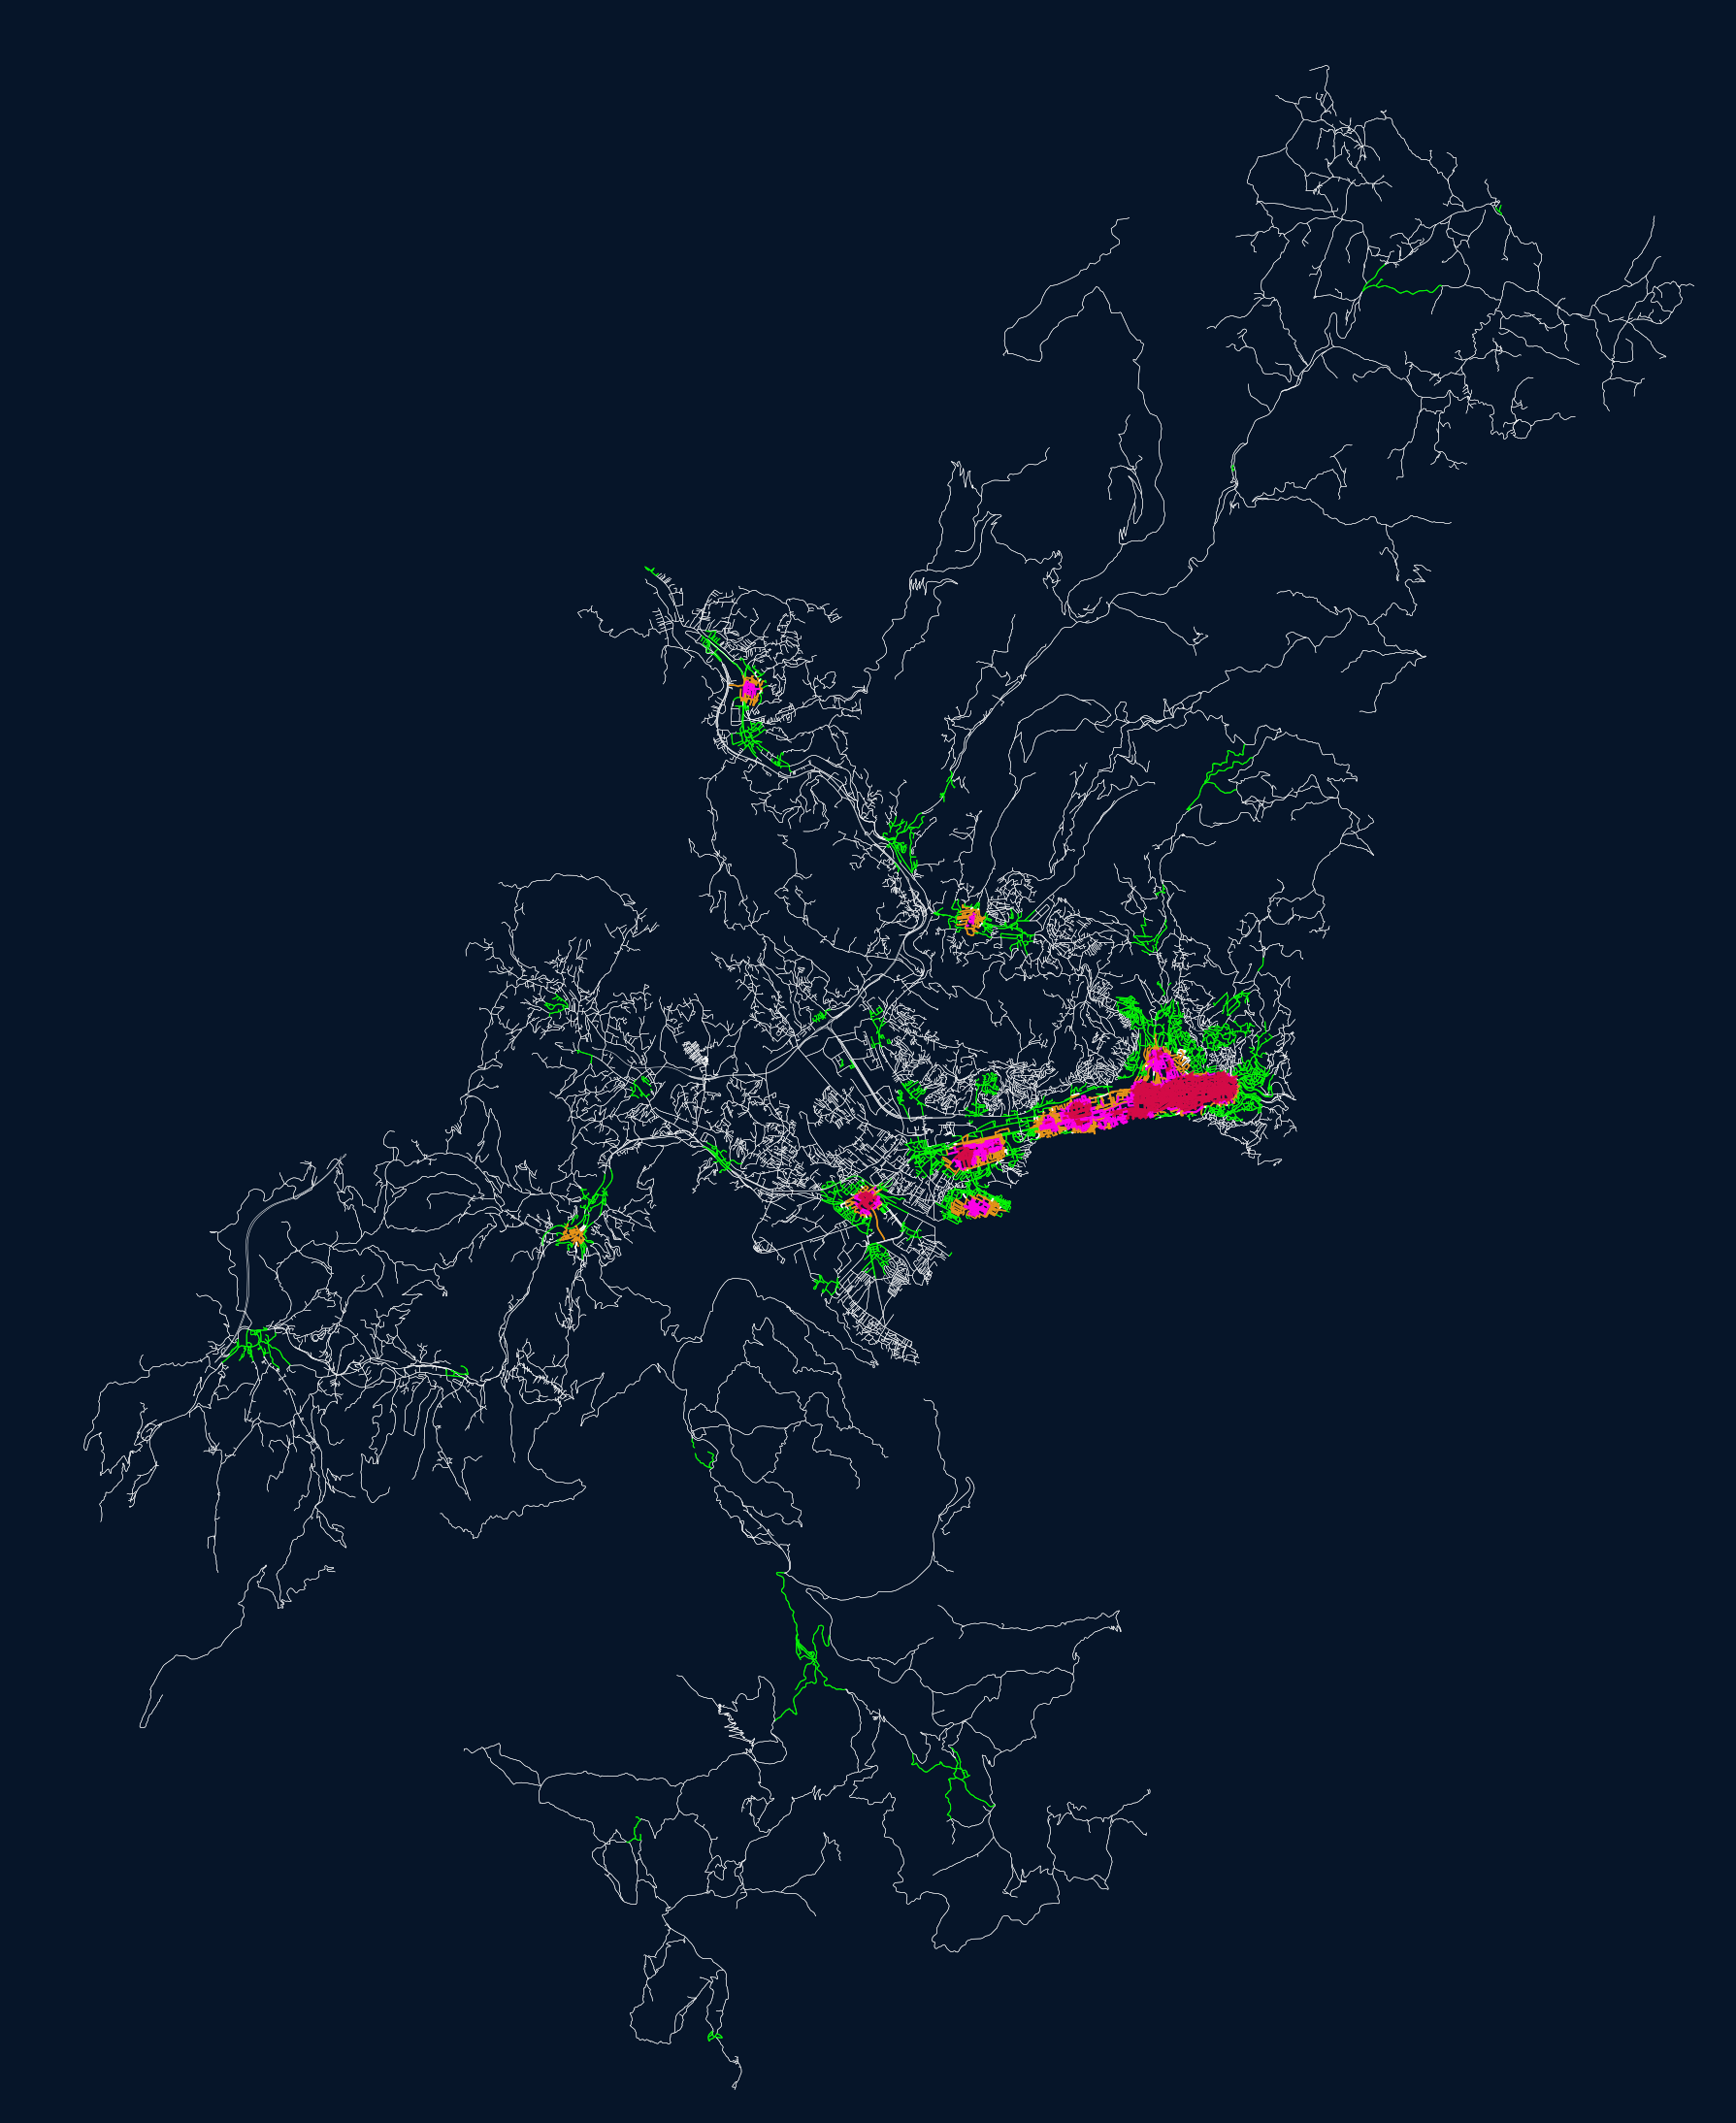

In [26]:
# Center of map
latitude = 43.860788
longitude = 18.407365

# Bbox sides - Custom for each network
north = latitude + 0.27
south = latitude - 0.26
east = longitude + 0.20
west = longitude - 0.4

# Make Map
fig, ax = ox.plot_graph(G, node_size=0, bbox = (north, south, east, west), margin = 0,
                        fig_height=40, fig_width=40, dpi = 300,  bgcolor = "#061529",
                        save = False, edge_color=roadColors,
                        edge_linewidth=roadWidths, edge_alpha=1)

x,y = saravejo_pol.exterior.xy
ax.plot(x,y,linewidth=.5, color='white')

# Text and marker size
markersize = 20
fontsize = 20

# Add legend
legend_elements = [Line2D([0], [0], marker='s', color="#061529", label= 'Alcohol Potential [1,5] Places',
                          markerfacecolor="#07f507", markersize=markersize),
                          
                  Line2D([0], [0], marker='s', color="#061529", label= 'Alcohol Potential [5,10] Places',
                         markerfacecolor="#e69419", markersize=markersize),
                  
                  Line2D([0], [0], marker='s', color="#061529", label= 'Alcohol Potential [10,15] Places',
                         markerfacecolor="#fc00e7", markersize=markersize),
                  
                  Line2D([0], [0], marker='s', color="#061529", label= 'Alcohol Potential > 10 Places',
                         markerfacecolor="#d40a47", markersize=markersize)]    
                      
l = ax.legend(handles=legend_elements, bbox_to_anchor=(0.0, 0.0), frameon=True, ncol=1,
              facecolor = '#061529', framealpha = 0.9,
              loc='lower left',  fontsize = fontsize, prop={'family':"Georgia", 'size':fontsize})  
  
# Legend font color
for text in l.get_texts():
    text.set_color("w")
    
# Save figure
fig.savefig('TEST.png', dpi=300, bbox_inches='tight', format="png", facecolor=fig.get_facecolor(), transparent=True)




# Output Image
add_border('TEST.png', output_image='TEST.png', fill = '#e0474c', bottom = 800)

# Open Image
img = Image.open('TEST.png')
draw = ImageDraw.Draw(img)

# Get font from working directory. Visit https://www.wfonts.com/search?kwd=pmingliu to download fonts
font = ImageFont.truetype("PMINGLIU.ttf", 650)

# Add font: position, text, color, font
draw.text((900,9200),"SARAJEVO, BOSNIA", (255,255,255), font=font)

# Save image
img.save('TEST.png')
